In [1]:
# %matplotlib notebook

import pandas as pd
import numpy as np
import spm1d
import matplotlib.pyplot as plt
import io
import ipywidgets as widgets
from IPython.display import Markdown as md
from IPython.display import display

In [2]:
def read_data(uploader):
    keys = list(uploader.value.keys())
    data = {}
    v = 0
    for k in keys:
        file = pd.read_excel(io.BytesIO(uploader.value[k]['content']), engine='openpyxl')
        file.columns = ['force1', 'force2']
        file['force'] = file['force1'] + file['force2']
        file = file.drop(['force1', 'force2'], axis=1)
        file = file.dropna()
        data[v] = file
        v = v+1
    return data

def cut_data(data, jump_type):
    data_cut = {}
    for d in data:
        sampling_frequency = 1000
        standing_length = 1

        quiet_standing_length = standing_length * sampling_frequency

        body_weight = data[d][0:quiet_standing_length]
        body_weight_mean = np.round(np.mean(body_weight['force']), 2)
        body_mass = np.round(body_weight_mean / 9.81, 2)

        body_weight_sd = np.round(np.std(body_weight['force']), 2)

        global_peak_force_index = data[d][data[d]['force'] == np.max(data[d]['force'])].index[0]

        global_minimum_force_index = data[d][data[d]['force'] == np.min(data[d]['force'])].index[0]

        first_peak_force_index = data[d][data[d]['force'] == np.max(data[d][0:global_minimum_force_index]['force'])].index[0]

        first_minimum_force_index = data[d][data[d]['force'] == np.min(data[d][0:first_peak_force_index]['force'])].index[0]

        if(jump_type == 'Countermovement Jump (cmj)'):
            initiation_threshold = np.round(body_weight_mean - body_weight_sd * 5, 2)
            inverse_threshold = np.round(body_weight_mean + body_weight_sd * 5, 2)

        if(jump_type == 'Squat Jump (sj)'):
            initiation_threshold = np.round(body_weight_mean + body_weight_sd * 5, 2)
            inverse_threshold = np.round(body_weight_mean - body_weight_sd * 5, 2)
            
        x = (data[d][0:first_minimum_force_index]['force'] <= initiation_threshold).to_frame()
        jump_threshold_index = max(x[x['force'] == True].index)

        pre_movement_maximum_force = max(data[d][int(jump_threshold_index - 0.1 * sampling_frequency):jump_threshold_index]['force'])
        x = (data[d][0:jump_threshold_index]['force'] == pre_movement_maximum_force).to_frame()
        pre_movement_maximum_force_index = max(x[x['force'] == True].index)

        x = (data[d][0:pre_movement_maximum_force_index]['force'] <= inverse_threshold).to_frame()
        jump_start_index = max(x[x['force'] == True].index) - round(0.029 * sampling_frequency)

        x = (data[d][0:pre_movement_maximum_force_index]['force'] <= inverse_threshold).to_frame()
        jump_start_index = max(x[x['force'] == True].index) - round(0.029 * sampling_frequency)
        
        final_data = data[d][jump_start_index:global_minimum_force_index]
        final_data = final_data.reset_index(drop = True)
    
        data_cut[d] = final_data
    return data_cut

def normalize(data_cut):
    from scipy.interpolate import interp1d
    resampled = []
    for c in data_cut:
        y_original = np.array(data_cut[c].dropna()).squeeze()
        x_original = np.linspace(0, len(y_original)-1, num=len(y_original), endpoint=True)
        x_new = np.arange(0, len(y_original)-1, len(y_original)/100)
        f = interp1d(x_original, y_original, kind='cubic')
        resampled_x = f(x_new)
        resampled.append(resampled_x)
    normalized = pd.DataFrame(resampled).T   
    normalized = normalized.round(decimals=1)
    return normalized

def test(sampleA, sampleB, alpha = 0.05, parametric = True):
    from matplotlib import pyplot
    import spm1d

    YA,YB = sampleA, sampleB
    
    if parametric == True:
        t = spm1d.stats.ttest_paired(YA, YB)
        ti = t.inference(alpha, two_tailed=True)
        print(ti)

    if parametric == False:
        t = spm1d.stats.nonparam.ttest2(YA, YB)
        ti = t.inference(alpha, two_tailed=False)
        print(ti)

    pyplot.close('all')

    p = pyplot.figure(figsize=(14, 4))
    ax = pyplot.axes((0.1, 0.15, 0.35, 0.8))
    spm1d.plot.plot_mean_sd(YA)
    spm1d.plot.plot_mean_sd(YB, linecolor='r', facecolor='r')
    ax.axhline(y=0, color='k', linestyle=':')
    ax.set_xlabel('normalized time [%]')
    ax.set_ylabel('force')
    
    ax = pyplot.axes((0.55,0.15,0.35,0.8))
    ti.plot()
    ti.plot_threshold_label(fontsize=8)
    ti.plot_p_values(size=10, offsets=[(0,0.3)])
    ax.set_xlabel('normalized time [%]')
    
    return ti, p

### Select jump type

In [3]:
jump_type = 'Squat Jump (sj)'
dropdown = widgets.Dropdown(options=['Squat Jump (sj)', 'Countermovement Jump (cmj)'])
dropdown.value = jump_type

def on_change(v):
    jump_type = v['new']
    
dropdown.observe(on_change, names='value')
display(dropdown)

Dropdown(options=('Squat Jump (sj)', 'Countermovement Jump (cmj)'), value='Squat Jump (sj)')

### Upload files for first trial 
Files must be in .xlsx format and contain only 2 columns with force values.

In [4]:
before_uploader = widgets.FileUpload(accept='.xlsx', multiple=True)
before_uploader.observe(on_change, names='value')
display(before_uploader)

FileUpload(value={}, accept='.xlsx', description='Upload', multiple=True)

In [5]:
button = widgets.Button(description="OK")
output_before = widgets.Output()

display(button, output_before)

def on_button_clicked(b):
    output_before.clear_output()
    with output_before:
        before_files = list(before_uploader.value.keys())
        display(md("Uploaded {} file(s) for first trial: \n\n {}".format(len(before_files),', '.join(before_files))))
        before_data = read_data(before_uploader)
        before_cut = cut_data(before_data, jump_type)
        before_norm = normalize(before_cut)
        x = plt.figure(figsize=(12,4))
        plt.plot(before_norm)
        plt.title('First trial (cut & normalized)')
        plt.xlabel('Normalized time [%]')
        plt.ylabel('Force')
        plt.show(x)

button.on_click(on_button_clicked)

Button(description='OK', style=ButtonStyle())

Output()

### Upload files for second trial 
Files must be in .xlsx format and contain only 2 columns with force values.

In [6]:
after_uploader = widgets.FileUpload(accept='.xlsx', multiple=True)
after_uploader.observe(on_change, names='value')
display(after_uploader)

FileUpload(value={}, accept='.xlsx', description='Upload', multiple=True)

In [7]:
button = widgets.Button(description="OK")
output_after = widgets.Output()

display(button, output_after)

def on_button_clicked(b):
    output_after.clear_output()
    with output_after:
        after_files = list(after_uploader.value.keys())
        display(md("Uploaded {} file(s) for second trial: \n\n {}".format(len(after_files),', '.join(after_files))))
        after_data = read_data(after_uploader)
        after_cut = cut_data(after_data, jump_type)
        after_norm = normalize(after_cut)
        
        x = plt.figure(figsize=(12,4))
        plt.plot(after_norm)
        plt.title('Second trial (cut & normalized)')
        plt.xlabel('Normalized time [%]')
        plt.ylabel('Force')
        plt.show(x)

button.on_click(on_button_clicked)

Button(description='OK', style=ButtonStyle())

Output()

# Run test

Button(description='RUN TEST', style=ButtonStyle())

Output()

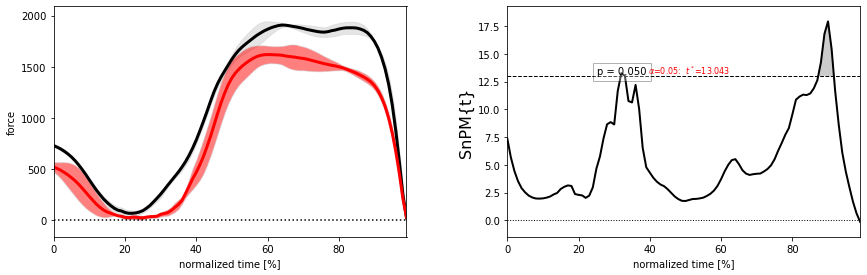

In [11]:
button_run = widgets.Button(description="RUN TEST")
output_run = widgets.Output()

display(button_run, output_run)

def on_button_clicked_run(b):
    output_run.clear_output()
    with output_run:
        before_data = read_data(before_uploader)
        before_cut = cut_data(before_data, jump_type)
        before_norm = normalize(before_cut)
        before_norm_np = before_norm.T.to_numpy()
        
        after_data = read_data(after_uploader)
        after_cut = cut_data(after_data, jump_type)
        after_norm = normalize(after_cut)
        after_norm_np = after_norm.T.to_numpy()
        
        h0 = []

        for i, j in zip(before_norm_np, after_norm_np):
            p  = spm1d.stats.normality.sw.regress(i,j)[1]
            p = round(p, 6)
            p_test = p < 0.05
            h0.append(p_test)

        if_parametric = all(h0)
       
        result, plot = test(before_norm_np, after_norm_np, alpha = 0.05, parametric = if_parametric)
        display(plot)

        if len(result.clusters) > 0:
            endpoints = []
            for c in result.clusters:
                e = np.round(c.endpoints, 1)
                endpoints.append(e)

            display(md("Endpoints for normalized time intervals with statistical differences: \n\n - {}".format('\n - '.join((map(str, endpoints))))))
        
        else:
             display(md("\n\nThere are no intervals with statistical differences."))

button_run.on_click(on_button_clicked_run)